In [1]:
KD_path = "ThuanHoa/KhoanhDat/ThuanHoa_TKDD2022.shp"
KetQuaPhanLoaiDat = "KetQuaPhanLoaiDat.tif"

In [2]:
import geopandas as gpd
import rasterio
import os
import rioxarray
import numpy as np
import xarray as xr

In [3]:
## map code
CODE_MAP = {
    "BHK": 2,
    "CLN": 3,
    "DGD": 6,
    "DGT": 6,
    "DNL": 6,
    "DRA": 6,
    "DSH": 6,
    "DTL": 5,
    "DTS": 6,
    "DYT": 6,
    "LUC": 1,
    "NKH": 3,
    "NTD": 6,
    "NTS": 4,
    "ONT": 6,
    "SKC": 6,
    "SKX": 6,
    "SON": 5,
    "TMD": 6,
    "TON": 6,
    "TSC": 6,
}

HT_MAP = {
    "NN": {
        "name": "Đất Nông Nghiệp",
        "data": [1, 2, 3, 4]
    },
    "PNN": {
        "name": "Đất Phi Nông Nghiệp",
        "data": [6]
    },
    "TQ": {
        "name": "Đất Thổ Quả",
        "data": [15]
    }
}

In [4]:
gdf = gpd.read_file(KD_path, crs="EPSG:9209")
polygon = gdf.geometry.values
label = gdf.tenchu.values

In [5]:
ouput_image = rioxarray.open_rasterio(KetQuaPhanLoaiDat)

In [6]:
result = {}
for key, values in HT_MAP.items():
    print(f"process {key}")
    array_list = []
    for i in range(len(polygon)):
        po = polygon[i]
        lb = label[i]
        code_lb = CODE_MAP.get(lb, 15)
        try:
            qr = ouput_image.rio.clip([po], "EPSG:9209")
            if code_lb in values["data"]:
                if code_lb == 6:
                    qr = qr.where((qr != 6.0), np.nan)
                    # qr = qr.where((qr != 3.0), np.nan)
                elif code_lb == 15:
                    qr = qr.where((qr != 6.0), np.nan)
                    qr = qr.where((qr != 3.0), np.nan)
                else: 
                    qr = qr.where(qr != float(code_lb), np.nan)
            else:
                qr.values[:, :, :] = np.nan
            array_list.append(qr)
        except Exception as e:
           pass
    result.update({key: array_list})

process NN
process PNN
process TQ


In [7]:
from rioxarray.merge import merge_arrays
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
colors = [
    "#abcee9",
    "#ffffc0",
    "#c4ff9e",
    "#ffd6a8",
    "#93ddda",
    "#1aeef7",
    "#ffa7f2",
    "#33ee33"
]
labels = [
    "Lúa tôm",
    "Lúa",
    "CHN",
    "CLN",
    "TS",
    "Sông",
    "Đất xây dựng",
    "Rừng"
]
cmap = ListedColormap(colors)

/tmp/ipykernel_17933/2997067873.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


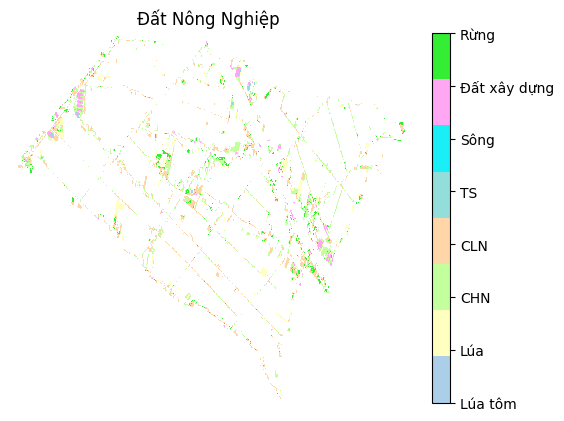

/tmp/ipykernel_17933/2997067873.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


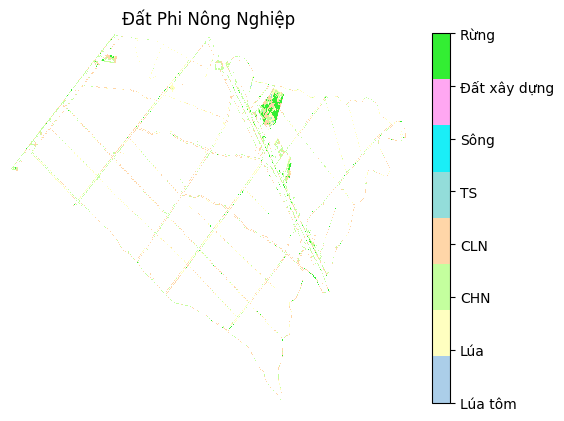

/tmp/ipykernel_17933/2997067873.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


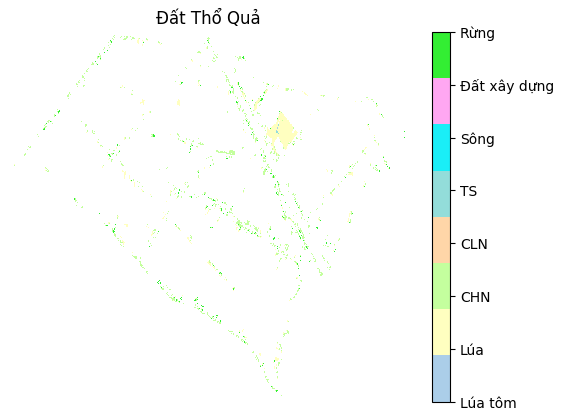

In [8]:
save_path = "ThuanHoa/KetQua"
if not os.path.exists(save_path):
    os.mkdir(save_path)

for k, v in result.items():
    rs = merge_arrays(v, nodata = np.nan)
    rs.rio.to_raster(f"{save_path}/{k}.tif")
    img = rs.plot(cmap=cmap, add_colorbar=False)
    cbar = plt.colorbar(img)
    cbar.ax.set_yticklabels(labels)
    plt.title(f'{HT_MAP[k]["name"]}')
    plt.axis('off')
    plt.show()